# 개와 고양이 분류를, 이미 잘 만들어진 뉴널네트워크를 활용하여, 성능을 올려보자.

![alt text](https://live.staticflickr.com/4544/38228876666_3782386ca7_b.jpg)

## Stage 1: Install dependencies and setting up GPU environment

In [51]:
# !pip install tensorflow-gpu==2.0.0.alpha0

In [52]:
# !pip install tqdm

### Downloading the Dogs vs Cats dataset

In [53]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2025-09-07 06:38:09--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M   339MB/s    in 0.2s    

2025-09-07 06:38:10 (339 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



## Stage 2: Dataset preprocessing

### Import project dependencies

In [54]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 파이썬의 진행상태를 표시해 주는 라이브러리
from tqdm import tqdm_notebook

from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
tf.__version__

'2.19.0'

### Unzipping the Dogs vs Cats dataset

In [55]:
dataset_path = "./cats_and_dogs_filtered.zip"

In [56]:
zip_object = zipfile.ZipFile(file=dataset_path, mode="r")

In [57]:
zip_object.extractall("./")

In [58]:
zip_object.close()

### Seting up dataset paths

In [59]:
dataset_path_new = "./cats_and_dogs_filtered/"

In [60]:
train_dir = os.path.join(dataset_path_new, "train")
validation_dir = os.path.join(dataset_path_new, "validation")

## Building the model : MobileNetV2 를 활용

## Loading the pre-trained model (MobileNetV2)

모바일이나, 임베디드에서도 실시간을 작동할 수 있게 모델이 경량화 되면서도, 정확도 또한 많이 떨어지지 않게하여, 속도와 정확도 사이의 트레이드 오프 문제를 어느정도 해결한 네트워크 입니다.

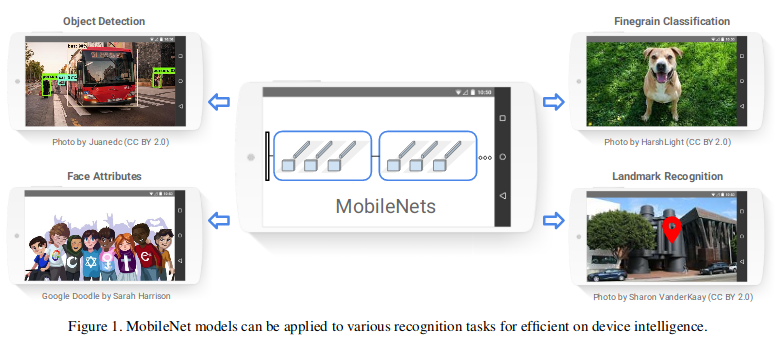

In [61]:
IMG_SHAPE = (128, 128, 3)

In [62]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")

In [63]:
base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

### Freezing the base model

In [64]:
base_model.trainable = False

### Defining the custom head for our network

In [65]:
base_model.output

<KerasTensor shape=(None, 4, 4, 1280), dtype=float32, sparse=False, ragged=False, name=keras_tensor_463>

In [66]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [67]:
global_average_layer

<KerasTensor shape=(None, 1280), dtype=float32, sparse=False, ragged=False, name=keras_tensor_464>

In [68]:
prediction_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')(global_average_layer)

### Defining the model

In [69]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [70]:
# model.summary()

### Compiling the model

In [71]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### Creating Data Generators

Resizing images

    Big pre-trained architecture support only certain input sizes.

For example: MobileNet (architecture that we use) supports: (96, 96), (128, 128), (160, 160), (192, 192), (224, 224).

In [72]:
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)

In [73]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(128,128), batch_size=128, class_mode="binary")

Found 2000 images belonging to 2 classes.


In [74]:
valid_generator = data_gen_valid.flow_from_directory(validation_dir, target_size=(128,128), batch_size=128, class_mode="binary")

Found 1000 images belonging to 2 classes.


### Training the model

In [75]:
model.fit(train_generator, epochs=5, validation_data=valid_generator)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 976ms/step - accuracy: 0.6246 - loss: 0.6655 - val_accuracy: 0.7310 - val_loss: 0.5567
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 265ms/step - accuracy: 0.7236 - loss: 0.5445 - val_accuracy: 0.7970 - val_loss: 0.4849
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.7965 - loss: 0.4731 - val_accuracy: 0.8430 - val_loss: 0.4265
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 339ms/step - accuracy: 0.8370 - loss: 0.4221 - val_accuracy: 0.8750 - val_loss: 0.3770
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 348ms/step - accuracy: 0.8705 - loss: 0.3774 - val_accuracy: 0.8980 - val_loss: 0.3354


### Transfer learning model evaluation

In [76]:
valid_loss, valid_accuracy = model.evaluate(valid_generator)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.8952 - loss: 0.3389


In [77]:
print("Accuracy after transfer learning: {}".format(valid_accuracy))

Accuracy after transfer learning: 0.8980000019073486


## Fine tuning


There are a few pointers:

- DO NOT use Fine tuning on the whole network; only a few top layers are enough. In most cases, they are more specialized. The goal of the Fine-tuning is to adopt that specific part of the network for our custom (new) dataset.
- Start with the fine tunning AFTER you have finished with transfer learning step. If we try to perform Fine tuning immediately, gradients will be much different between our custom head layer and a few unfrozen layers from the base model.

### Un-freeze a few top layers from the model

In [78]:
base_model.trainable = True

In [79]:
print("Number of layersin the base model: {}".format(len(base_model.layers)))

Number of layersin the base model: 154


In [80]:
fine_tune_at = 100

In [81]:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

### Compiling the model for fine-tuning

In [82]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Fine tuning

In [83]:
model.fit(train_generator,
                    epochs=5,
                    validation_data=valid_generator)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8587 - loss: 0.3035 - val_accuracy: 0.9710 - val_loss: 0.0768
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.9975 - loss: 0.0300 - val_accuracy: 0.9730 - val_loss: 0.0755
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 0.9700 - val_loss: 0.0793
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.9740 - val_loss: 0.0815
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 386ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9730 - val_loss: 0.0853


### Evaluating the fine tuned model

In [84]:
valid_loss, valid_accuracy = model.evaluate(valid_generator)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.9751 - loss: 0.0951


In [85]:
print("Validation accuracy after fine tuning: {}".format(valid_accuracy))

Validation accuracy after fine tuning: 0.9729999899864197


### 이미지파일 테스트 해본다.

In [89]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to the image you want to test
image_path = '/content/cats_and_dogs_filtered/validation/cats/cat.2000.jpg' # Replace with your image path

img = image.load_img(image_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0 # Rescale the image

# Make a prediction
prediction = model.predict(img_array)

# Interpret the prediction
if prediction[0] > 0.5:
    print("This is a dog!")
else:
    print("This is a cat!")

print("Prediction score: ", prediction[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
This is a cat!
Prediction score:  [7.861773e-07]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


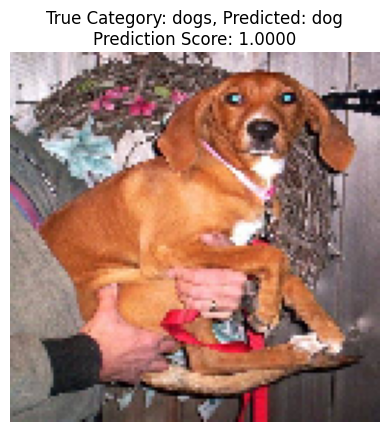

In [94]:
import random
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to get a random image path from the dataset
def get_random_image(base_dir):
    categories = ['cats', 'dogs']
    category = random.choice(categories)
    category_dir = os.path.join(base_dir, category)
    image_name = random.choice(os.listdir(category_dir))
    image_path = os.path.join(category_dir, image_name)
    return image_path, category

# Path to the validation dataset
validation_data_dir = './cats_and_dogs_filtered/validation'

# Get a random image path and its true category
random_image_path, true_category = get_random_image(validation_data_dir)

# Load and preprocess the image
img = image.load_img(random_image_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Make a prediction
prediction = model.predict(img_array)

# Interpret the prediction
if prediction[0] > 0.5:
    predicted_category = "dog"
else:
    predicted_category = "cat"

# Display the image and prediction
plt.imshow(img)
plt.title(f"True Category: {true_category}, Predicted: {predicted_category}\nPrediction Score: {prediction[0][0]:.4f}")
plt.axis('off')
plt.show()